Found 2630 files belonging to 2 classes.
Found 563 files belonging to 2 classes.
Found 566 files belonging to 2 classes.


Model: "TL_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Sınıf Ağırlıkları -> Kuş: 1.49, Dron: 0.75
Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.7712 - loss: 0.4867
Epoch 1: val_loss improved from inf to 0.10441, saving model to best_tl_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 49s 543ms/step - accuracy: 0.7725 - loss: 0.4844 - val_accuracy: 0.9609 - val_loss: 0.1044 - learning_rate: 0.0010
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9521 - loss: 0.1189
Epoch 2: val_loss improved from 0.10441 to 0.06362, saving model to best_tl_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 495ms/step - accuracy: 0.9522 - loss: 0.1187 - val_accuracy: 0.9787 - val_loss: 0.0636 - learning_rate: 0.0010
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9642 - loss: 0.0994
Epoch 3: val_loss improved from 0.06362 to 0.05590, saving model to best_tl_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 518ms/step - accuracy: 0.9642 - loss: 0.0993 - val_accuracy: 0.9787 - val_loss: 0.0559 - learning_rate: 0.0010
Epoch 4/10
8

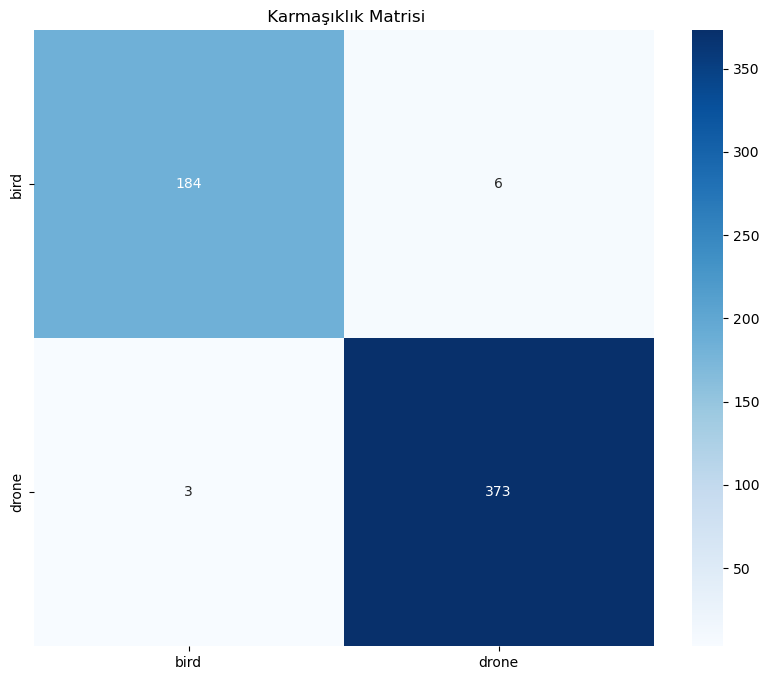

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

BASE_PATH = "C:/Users/mkasl/Desktop/donem5/yap470/Ara_rapor_ 1/final_dataset1"
TRAIN_PATH = os.path.join(BASE_PATH, 'train') 
VALID_PATH = os.path.join(BASE_PATH, 'valid')
TEST_PATH = os.path.join(BASE_PATH, 'test')

#Çözünürlüğü biraz arttırdım.
IMAGE_SIZE = (224, 224) 
BATCH_SIZE = 32
tf.random.set_seed(42)
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 30 #Fine tuning aşaması

#-1 ve 1 arasına getirmek için ön işleme
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#veri setlerini yükleme
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH, labels='inferred', label_mode='categorical',
    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=True, seed=42)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALID_PATH, labels='inferred', label_mode='categorical',
    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH, labels='inferred', label_mode='categorical',
    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.class_names
#Burası cache gibi önbellekleme vs. kullanıp performansı arttırmaya çalıştığım kısım ama buna rağmen daha farklı şeylere
#ihtiyacım var prefecthi sonraki batchi hazırlar cache önbelleğe alır
AUTOTUNE = tf.data.AUTOTUNE
#Düzeltme hata alıyorum bu modele uygun hale getiriyorum -1 ile 1 arasında input bekliyor
def prepare(dataset):
    #beklenen formata getirir.
    dataset = dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    return dataset.cache().prefetch(buffer_size=AUTOTUNE) #Bunu yapmazsam hata alıyorum bu modele uygun hale getiriyorum -1 ile 1 arasında input bekliyor 

train_dataset = prepare(train_dataset)
validation_dataset = prepare(validation_dataset)
test_dataset = prepare(test_dataset)

#Modeli oluşturma kısmı burada google'ın mobilenetv2 modelini kullandım.
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                               include_top=False, #Sadece öznitelik çıkaran kısmını alıyoruz
                                               weights='imagenet') #Eğitilmiş ağırlıklarıyla birlikte
#https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2
base_model.trainable = False 
inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = base_model(inputs, training=False)
#GlobalAveragePooling2D sınıflandırıcısı ekliyorum dondurulan modele
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs, name="TL_Model")
model.summary()

#Sınıf Ağırlıklandırma uzaktaki kuş ve droneları karıştırmaması için
num_birds = len(os.listdir(os.path.join(TRAIN_PATH, 'bird')))
num_drones = len(os.listdir(os.path.join(TRAIN_PATH, 'drone')))
total_train_samples = num_birds + num_drones
weight_for_bird = (1 / num_birds) * (total_train_samples / 2.0)
weight_for_drone = (1 / num_drones) * (total_train_samples / 2.0)
class_weights = {class_names.index('bird'): weight_for_bird, class_names.index('drone'): weight_for_drone}
print(f"\nSınıf Ağırlıkları -> Kuş: {weight_for_bird:.2f}, Dron: {weight_for_drone:.2f}")

#Eski modelde kullandığım callbacklar Dynamic learning early stopping vs.
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='best_tl_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-6)
]

#https://www.tensorflow.org/tutorials/images/transfer_learning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#üst katmanları eğitiyoruz ilk başta
history = model.fit(train_dataset,
                    epochs=INITIAL_EPOCHS,
                    validation_data=validation_dataset,
                    callbacks=callbacks,
                    class_weight=class_weights)
#finetuning aşaması
base_model.trainable = True #öğrenmesini açıyorum
#Önceden eğitilen model üzerine çok dokunamk istemediğimden çok düşük bir öğrenme oranı kullandım
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print("\n>>> Fine tuning aşaması model eğitimi.")
total_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
history_fine_tune = model.fit(train_dataset,
                              epochs=total_epochs,
                              initial_epoch=history.epoch[-1] + 1,
                              validation_data=validation_dataset,
                              callbacks=callbacks,
                              class_weight=class_weights)


test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"\nTest Seti Doğruluğu: {test_accuracy:.4f}")

# Karmaşıklık Matrisi
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = np.argmax(y_true_labels, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8)) 
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(' Karmaşıklık Matrisi')
plt.show()